# Защита персональных данных клиентов

**Задача**

Необходимо защитить данные клиентов страховой компании «Хоть потоп». Нужно разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию, и обосновать корректность его работы (при преобразовании качество моделей машинного обучения не должно ухудшиться).

**Описание данных**

*Признаки:*

- пол,
- возраст,
- зарплата застрахованного,
- количество членов его семьи.

*Целевой признак:*

- количество страховых выплат клиенту за последние 5 лет.

## Загрузка данных

In [ ]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [ ]:
# загружаем датасет
data = pd.read_csv('/datasets/insurance.csv')

Изучим общую информацию о данных:

In [ ]:
data.sample(7)

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
786,1,37.0,51900.0,1,0
1739,1,27.0,49700.0,1,0
4619,1,35.0,40300.0,2,0
3186,1,36.0,39400.0,4,0
4105,0,20.0,37200.0,2,0
2900,1,36.0,25100.0,2,0
4751,1,28.0,32500.0,0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [ ]:
data.describe()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


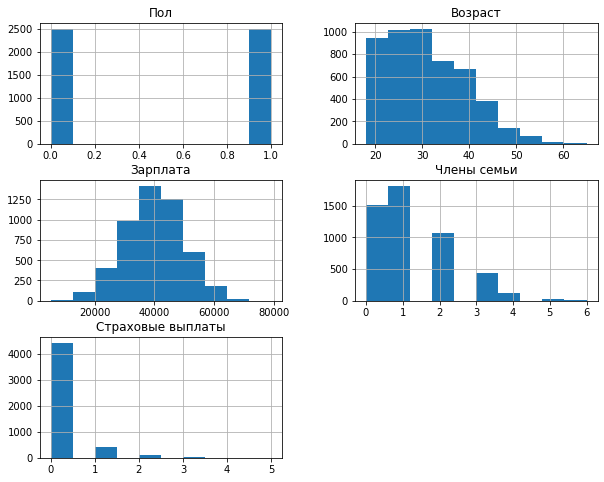

In [ ]:
data.hist(figsize = (10,8));

In [ ]:
print('Количество явных дубликатов:',data.duplicated().sum())
print('Доля дубликатов в общем количестве данных,%:', (data.duplicated().sum() / len(data))*100)

Количество явных дубликатов: 153
Доля дубликатов в общем количестве данных,%: 3.06


Совпадение клиентов по всем признакам маловероятно, удалим явные дубликаты:

In [ ]:
data = data.drop_duplicates().reset_index(drop=True)

print('Количество явных дубликатов после очистки:',data.duplicated().sum())

Количество явных дубликатов после очистки: 0


Для удобства переименуем столбцы:

In [ ]:
data = data.rename(columns={"Пол": "sex",
                            "Возраст": "age",
                            "Зарплата": "salary",
                            "Члены семьи": "members_of_family",
                            "Страховые выплаты":"insurance_payments"})

In [ ]:
data.head(5)

,sex,age,salary,members_of_family,insurance_payments
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


### Вывод

- В предоставленном датасете 5000 строк и 5 столбцов.
- В данных присутствовали явные дубликаты (3%), которые мы удалили.
- Пропусков, аномалий и вбросов не наблюдается.

## Умножение матриц

**Ответьте на вопрос и обоснуйте решение:**

 Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии? (Её можно обучить заново.)

a. Изменится. Приведите примеры матриц.

b. Не изменится. Укажите, как связаны параметры линейной регрессии в исходной задаче и в преобразованной.

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

- $w'$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу) при умножении признаков на обратимую матрицу

- $E$ - единичная матрица

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:** Качество линейной регрессии не изменится.

**Обоснование:**

$a1$ - это предсказания в случае, когда признаки не умножаются на обратимую матрицу;
   
$a2$ - это предсказания в случае, когда признаки умножаются на обратимую матрицу.

Докажем, что $a1$ = $a2$.

$$
a1 = Xw = X(X^T X)^{-1} X^T y
$$
$$
a2 = XPw' = XP((XP)^T XP)^{-1} (XP)^T y
$$

$$
X(X^T X)^{-1} X^T y = XP((XP)^T XP)^{-1} (XP)^T y
$$

Для решения уравнения нам понадобятся следующие свойства матричных операций:

$$
(AB)^T = B^TA^T
$$

$$
(AB)^{-1} = B^{-1}A^{-1}
$$

$$
AA^{-1} = A^{-1}A = E
$$


Будем работать с правой частью уравнения:

$$
X(X^T X)^{-1} X^T y = XP(P^TX^TXP)^{-1} (XP)^T y
$$

$X^TX$ и P квадратные матрицы (P по условию задачи обратимая, а значит квадратная), поэтому можно раскрыть скобки:

$$
X(X^T X)^{-1} X^T y = XP (P^T)^{-1} (X^TX)^{-1} P^{-1} P^T X^T y
$$

$$
X(X^T X)^{-1} X^T y = X\underbrace{(P^T)^{-1} P^T}_\textrm{E}(X^TX)^{-1}\underbrace{PP^{-1}}_\textrm{E} X^T y
$$

Умножение на единичную матрицу приводит к получению той же самой матрицы, поэтому можно сократить:

$$
X(X^T X)^{-1} X^T y = X (X^TX)^{-1} X^T y
$$

$$
a1 = a2
$$

Таким образом, мы доказали, что качество линейной регрессии при умножении признаков на обратимую матрицу не меняется.

Посмотрим, как связаны параметры линейной регрессии в исходной задаче и в преобразованной:

$$
w = (X^T X)^{-1} X^T y
$$

$$
w' = ((XP)^T XP)^{-1} (XP)^T y
$$

Пробразуем формулу обучения:


$$
w' = (P^T X^T XP)^{-1} (XP)^T y
$$

$$
w' = (P^T)^{-1} (X^T X)^{-1} P^{-1} P^T X^T y
$$

$$
w' = \underbrace{(P^T)^{-1} P^T}_\textrm{E}(X^TX)^{-1} P^{-1} X^T y
$$

$$
w' = P^{-1} (X^TX)^{-1} X^T y
$$

В таком случае параметры линейной регрессии в преобразованной задаче будут связаны с параметрами исходной задачи cледующим образом:

$$
w' = P^{-1} w
$$

## Алгоритм преобразования

**Предложите алгоритм преобразования данных для решения задачи. Обоснуйте, почему качество линейной регрессии не поменяется.**

**Алгоритм**

1. Создадим рандомную обратимую матрицу 4x4, так как исходные данные содержат 4 признака.
2. Умножаем признаки обучающей и тестовой выборок на обратимую матрицу, получаем матрицы с зашифрованными признаками.
3. Обучаем модель линейной регрессии на преобразованных тренировочных данных, предсказания получаем на тестовых.
4. Обучаем модель на непреобразованных данным и получаем предсказания.
5. Сравниваем показатели метрики R2 моделей.
6. В случае успешного теститрования алгоритма напишем дешифратор для возвращения признаков к исходному виду - функцию, которая зашифрованные данные умножает на матрицу, обратную рандомной.

**Обоснование**

Для преобразования данных будем использовать доказанное выше свойство умножения на обратимую матрицу. В таком случае качество линейной регрессии не меняется, а преобразованные данные можно восстановить благодаря следующему свойству обратной матрицы: $ AA^{-1} = A^{-1}A = E $

## Проверка алгоритма

### Подготовка выборок

Выделим из датасета признаки и целевой признак:

In [ ]:
features = data.drop('insurance_payments',axis=1)
target = data['insurance_payments']

Разделим данные на две выборки - обучающую и тестовую в соотношении 75/25:

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                              target,
                                                                              test_size=0.25,
                                                                              random_state=12345)
print(target_train.shape, target_test.shape)
print(features_train.shape, features_test.shape)

(3635,) (1212,)
(3635, 4) (1212, 4)


Создадим рандомную обратимую матрицу 4x4. Проверку обратимости будем осуществлять с помощью метода **inv( )**. Если матрица не имеет обратной матрицы, то метод **inv( )** вызовет исключение LinAlgError: Singular matrix.

In [ ]:
random_matrix = np.random.rand(4, 4)
np.linalg.inv(random_matrix)

array([[-1.17989772, -0.04601491,  2.65567636,  0.74615887],
       [ 3.08955542, -0.77132674, -2.23860805, -1.84596074],
       [-0.98692985,  2.43317528, -0.54395942,  0.24650851],
       [ 0.211588  , -0.81780933,  0.10699803,  1.04767335]])

Преобразуем обучающую и тестовую выборку с помощью обратимой матрицы:

In [ ]:
features_train_encrypted = features_train.values @ random_matrix
features_test_encrypted = features_test.values @ random_matrix
print(features_train_encrypted)
print('')
print(features_test_encrypted)

[[34018.72358487 14705.67300154  5451.62593681   401.70006791]
 [31651.78801206 13684.66323651  5078.44164017   375.3169759 ]
 [17481.12163905  7558.23449687  2806.30098034   207.82535941]
 ...
 [18041.82702869  7800.32165286  2894.19803391   214.354793  ]
 [24224.31188751 10474.08867257  3888.87324523   288.19185443]
 [29530.81408004 12768.18863933  4741.01290071   351.4416374 ]]

[[29462.04238198 12736.02753112  4720.51510419   346.66853778]
 [41134.2203027  17781.57614628  6590.48768685   483.75459046]
 [21166.82014558  9152.82306781  3400.57232472   253.58229244]
 ...
 [20914.69485472  9042.83957889  3357.04520189   250.55666036]
 [20663.78932444  8933.74787918  3315.11625941   244.03958473]
 [20487.08203406  8861.77596279  3300.7768937    247.40814985]]


### Сравнение качества моделей с преобразованием признаков и без него

Сначала обучим модель линейной регрессии без преобразования признаков и посмотрим на коэффициент детерминации:

In [ ]:
model_1 = LinearRegression()
model_1.fit(features_train, target_train)
predictions = model_1.predict(features_test)
r2_model_1 = r2_score(target_test, predictions)

print('Метрика R2 модели без преобразования признаков:',r2_model_1)

Метрика R2 модели без преобразования признаков: 0.42307727492147584


Обучим модель на преобразованных данных и сравним показатели метрики:

In [ ]:
model_2 = LinearRegression()
model_2.fit(features_train_encrypted, target_train)
predictions = model_2.predict(features_test_encrypted)
r2_model_2 = r2_score(target_test, predictions)

print('Метрика R2 модели с преобразованием признаков:',r2_model_2)

Метрика R2 модели с преобразованием признаков: 0.42307727492132896


In [ ]:
print('Разница метрик:', r2_model_1 - r2_model_2)

Разница метрик: 1.468825061579082e-13


Разница метрик незначительная, а связана она с округлениями при вычислениях.

Для того чтобы расшифровать данные, необходимо умножить преобразованные признаки на матрицу, обратную рандомной матрице:

In [ ]:
matrix_after_transform = features_train_encrypted @ np.linalg.inv(random_matrix)

# проверим, совпадут ли исходные значения признаков и значения признаков после преобразований
res = list(np.array(features_train.values.round(4)==matrix_after_transform.round(4)).reshape(-1,))
print(f'{res.count(True)}/{len(res)}')

14540/14540


Напишем функцию, которая будет своебразным дешифратором:

In [ ]:
def decoder (encrypted_data, matrix):
    decrypted_data = encrypted_data @ np.linalg.inv(random_matrix)
    decrypted_data = pd.DataFrame(data=data, columns=["sex", "age", "salary", "members_of_family"])
    return decrypted_data

In [ ]:
decoder (features_train_encrypted, random_matrix)

,sex,age,salary,members_of_family
0,1,41.0,49600.0,1
1,0,46.0,38000.0,1
2,0,29.0,21000.0,0
3,0,21.0,41700.0,2
4,1,28.0,26100.0,0
...,...,...,...,...
4842,0,28.0,35700.0,2
4843,0,34.0,52400.0,1
4844,0,20.0,33900.0,2
4845,1,22.0,32700.0,3


## Вывод

В данном исследовании нашей задачей было разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию, при этом преобразования не должны влиять на качество моделей машинного обучения.

В качестве алгоритма преобразования мы использовали умножение матрицы признаков на обратимую случайную матрицу, так как нами было доказано, что такое преобразование не влияет на качество модели линейной регрессии, а зашифрованные данные можно привести к исходному виду с помощью матрицы, обратной случайной.

Для тестирования алгоритма мы сравнивали качество модели, обученной на исходных данных, и модели, обученной на преобразованных данных. Разница в метриках оказалась незначительной (накопительная ошибка при округлениях), а значит алгоритм может использоваться для решения  задачи защиты персональных данных.